# Plotting animations from time series imagery

**What does this notebook do?** 

This notebook demonstrates how to import a time series of DEA cloud-free Landsat imagery from multiple sensors (i.e. Landsat 5, 7 and 8) as an xarray dataset, and then plot the data as a time series animation with one or two panels that can be either one or three-band images (e.g. true and false colour), or with a line graph (e.g. a pixel drill) in the right column. Animations can be produced as either GIFs, MP4s or WMVs for any area in Australia using a standard datacube query.

**Required inputs**

This example uses three external functions called `load_clearlandsat`, `animated_timeseries`, `animated_doubletimeseries` and `animated_timeseriesline`. These functions are available in the `10_Scripts` folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/10_Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** August 2018

**Author:** Robbi Bishop-Taylor

In [1]:
# Import modules
import datacube 
import sys
import os
import pandas as pd

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../10_Scripts')
import DEADataHandling
import DEAPlotting

# Set up datacube instance
dc = datacube.Datacube(app='Time series animation')

%load_ext autoreload
%autoreload 2

## Set up datacube query
Define the query bounds for datacube extraction using a dict. This should include `x` and `y` limits, potentially a list of `measurements` (i.e. the bands you want to extract like 'red', 'green', 'blue'; this significantly speeds up the import) and a `time` extent. If no `time` is given, the function defaults to all timesteps available to all sensors (e.g. 1987-2018).

In [2]:
# Set up spatial and temporal query.
query = {'x': (970476, 987476),
         'y': (-3568950, -3551951),
         'time': ('2015-01-01', '2018-01-01'),
         'crs': 'EPSG:3577'}

## Extract cloud-free clear Landsat observations from all sensors
Use the `load_clearlandsat` function to load Landsat observations and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and return a single xarray dataset containing only observations that contain greater than a specified proportion of clear pixels. This uses `dask` to only load in the filtered observations, and results in a visually appealing time series of observations that are not affected by cloud!

    Skipping ls5
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 0 filtered ls7 timesteps
Loading ls8 PQ
    Loading 33 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
<xarray.Dataset>
Dimensions:    (time: 33, x: 680, y: 680)
Coordinates:
  * y          (y) float64 -3.552e+06 -3.552e+06 -3.552e+06 -3.552e+06 ...
  * x          (x) float64 9.705e+05 9.705e+05 9.705e+05 9.706e+05 9.706e+05 ...
  * time       (time) datetime64[ns] 2015-01-22T00:20:21 2015-02-07T00:20:18 ...
Data variables:
    red        (time, y, x) float64 1.001e+03 1.01e+03 1.165e+03 1.288e+03 ...
    green      (time, y, x) float64 823.0 825.0 880.0 931.0 957.0 964.0 ...
    blue       (time, y, x) float64 650.0 648.0 633.0 635.0 639.0 634.0 ...
    nir        (time, y, x) float64 1.623e+03 1.62e+03 1.922e+03 2.097e+03 ...
    swir1      (time, y, x) float64 2.821e+03 2.806e+03 3.076e+03 3.287e+03 ...
    data_perc  (time) float64 1.0 0.9999 0.9996 0.9919 0.9985 1.0 1.0 1.0 ...
Att

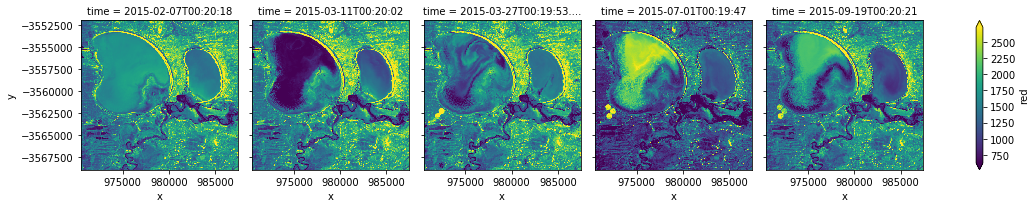

In [3]:
# Set the minimum proportion of clear pixels (pixels with no clouds or other nodata)
masked_prop=0.99

# Load in only clear Landsat observations with < 1% unclear values
ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, 
                                       bands_of_interest=['red', 'green', 'blue', 'nir', 'swir1'], 
                                       masked_prop=masked_prop)  
print(ds)

# Plot first five time series images (just using the red band for simplicity):
ds.red.isel(time=[1, 2, 3, 4, 5]).plot(col="time", robust=True)

## Plot entire time series as a one-panel animated GIF
The `animated_timeseries` function takes an xarray time series and exports a one band or three band (e.g. true or false colour) GIF, MP4 or WMV animation showing changes in the landscape across time. Here, we plot the xarray as an animated GIF that includes a date annotation for each frame. We set the interval between the animation frames to 80 milliseconds. For three-band RGB animations like this, the function will automatically select an appropriate colour stretch by clipping the data to remove values smaller or greater than the 2 and 98th percentiles. This can be controlled further with the `percentile_stretch` parameter.

Generating 33 frame animation
    Exporting animation to animated_timeseries.gif


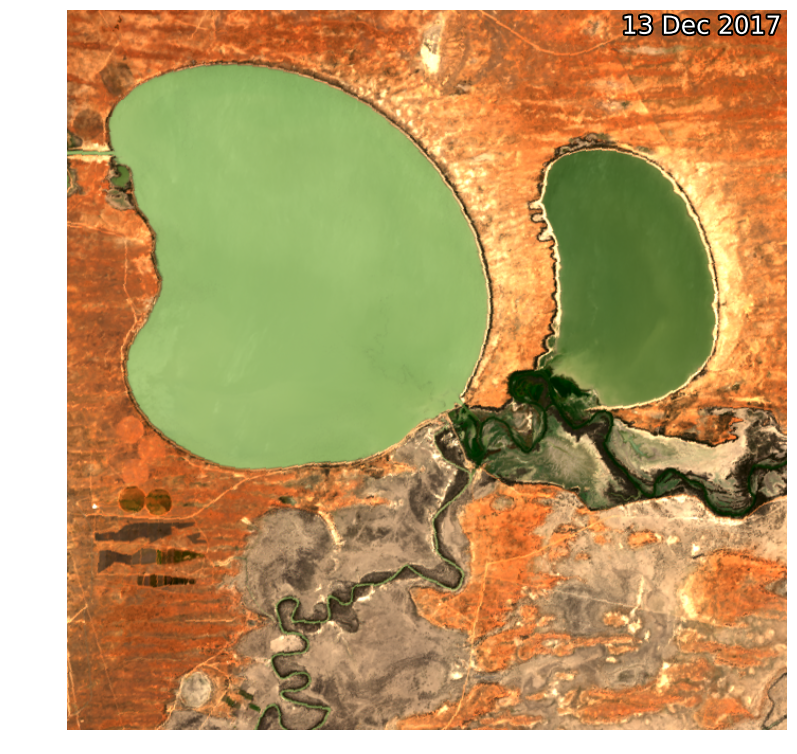

In [23]:
# Produce time series animation of red, green and blue bands
DEAPlotting.animated_timeseries(ds=ds, output_path="animated_timeseries.gif", interval=80) 

We can also use different band combinations (e.g. false colour), add a title, and change the font size using `annotation_kwargs`, which passes a dictionary of values to the matplotlib `plt.annotate` function (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html for options):

Generating 33 frame animation
    Exporting animation to animated_timeseries.gif


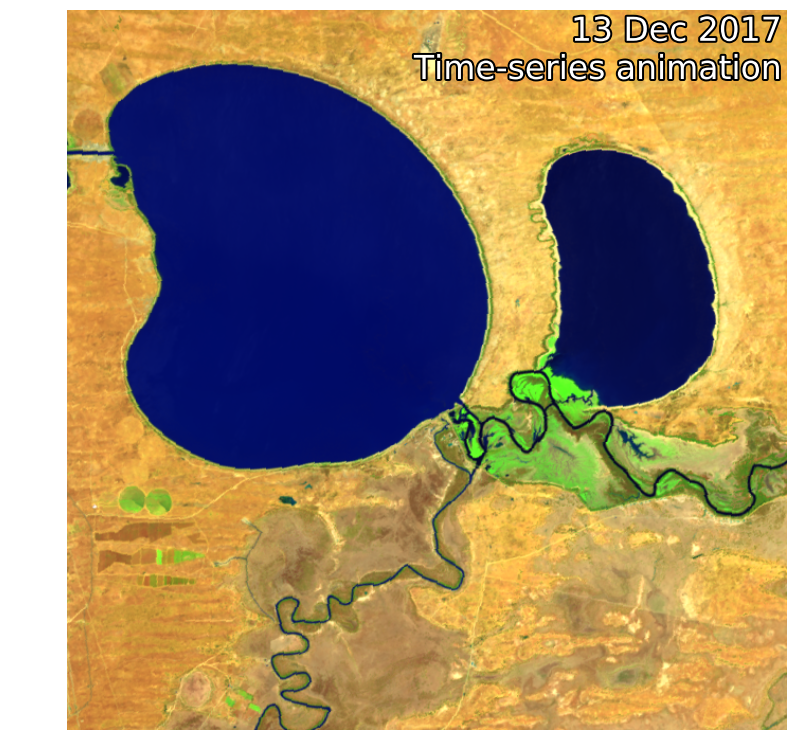

In [24]:
# Produce time series animation of red, green and blue bands
DEAPlotting.animated_timeseries(ds=ds, output_path="animated_timeseries.gif", 
                                bands=['swir1', 'nir', 'green'],
                                title="Time-series animation",
                                interval=80, percentile_stretch=[0.01, 0.99],
                                annotation_kwargs={'fontsize': 33}) 

It is also possible to plot a single band image instead of a three band. For example, we could plot an index like the Normalized Difference Water Index (NDWI), which has high values where a pixel is likely to be open water (e.g. NDWI > 0):

Generating 33 frame animation
    Exporting animation to animated_timeseries.gif


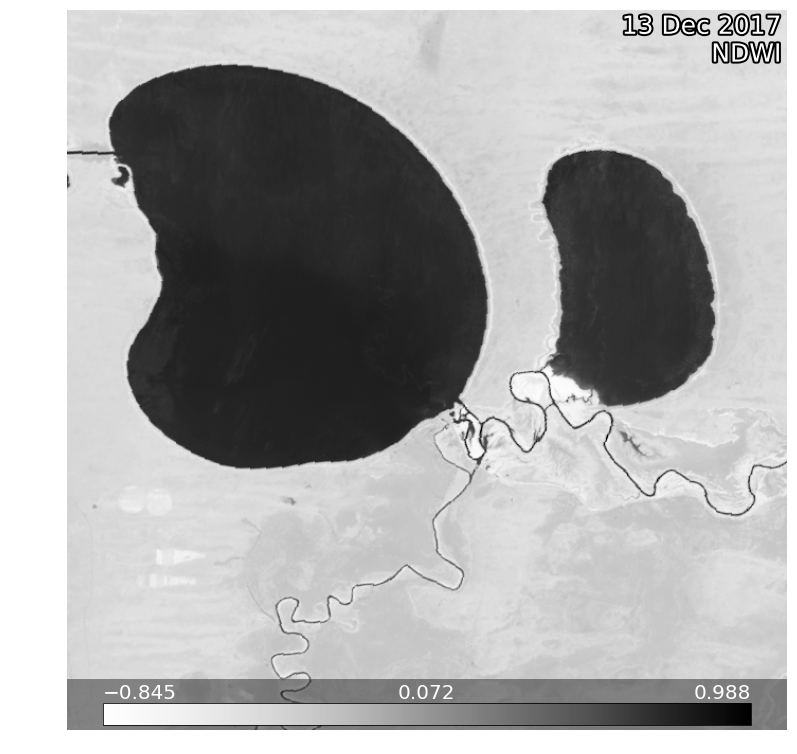

In [25]:
# Compute NDWI using the formula (green - nir) / (green + nir). This will calculate 
# NDWI for every time-step in the dataset:
ds_ndwi = (ds.green - ds.nir) / (ds.green + ds.nir)
ds_ndwi 

# We can now add this back into our dataset as a new data variable:
ds["NDWI"] = ds_ndwi

# Produce time series animation of NDWI:
DEAPlotting.animated_timeseries(ds=ds, output_path="animated_timeseries.gif", 
                                bands=['NDWI'], title="NDWI", interval=80) 

We can customise animations based on a single band like NDWI by specifying parameters using the `onebandplot_kwargs` which will be sent to the matplotlib `plt.imshow` function (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html for options). For example, we can use a more appropriate blue colour scheme, and set custom colour bar limits:

Generating 33 frame animation
    Exporting animation to animated_timeseries.gif


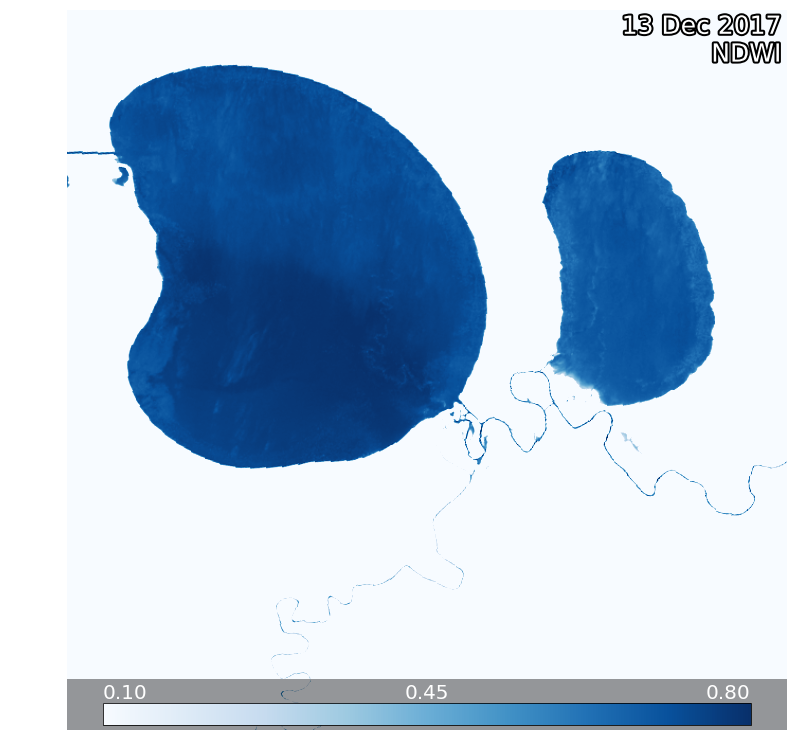

In [26]:
# Produce time series animation using a custom colour scheme and limits:
DEAPlotting.animated_timeseries(ds=ds, output_path="animated_timeseries.gif", 
                                bands=['NDWI'], title="NDWI", interval=80,
                                onebandplot_kwargs={'cmap':'Blues', 'vmin':0.1, 'vmax':0.8}) 

One band animations show a colour bar by default, but this can be disabled:

Generating 33 frame animation
    Exporting animation to animated_timeseries.gif


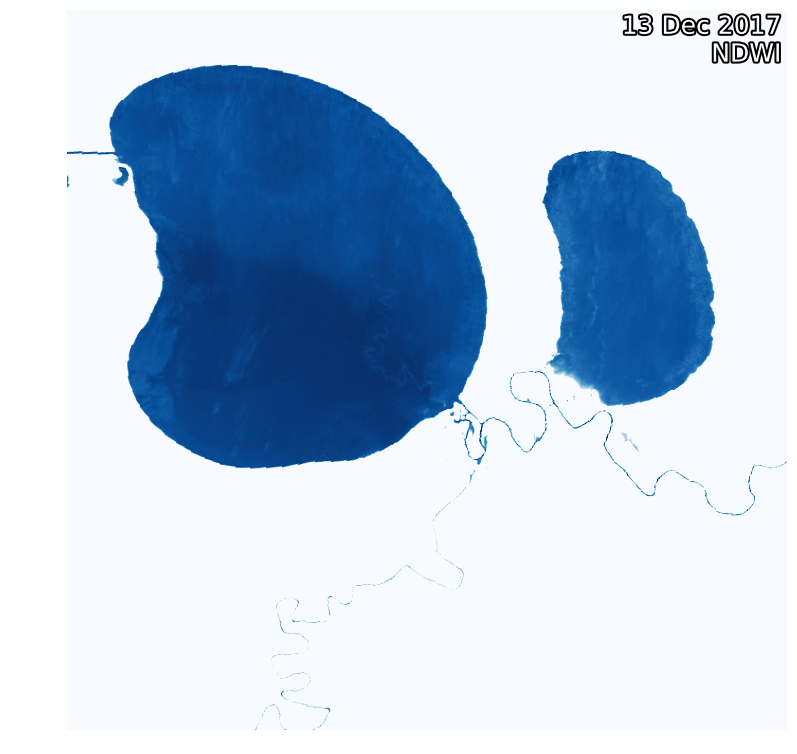

In [27]:
# Produce time series animation without a colour bar:
DEAPlotting.animated_timeseries(ds=ds, output_path="animated_timeseries.gif", 
                                bands=['NDWI'], title="NDWI", interval=80,
                                onebandplot_cbar=False,
                                onebandplot_kwargs={'cmap':'Blues', 'vmin':0.1, 'vmax':0.8}) 

## Plot a two panel side-by-side animation
We can use the `animated_doubletimeseries` function to plot an animation that compares two different xarray datasets or band combinations at the same time:

Generating 33 frame animation (i.e. timesteps in shortest dataset)
    Exporting animation to animated_doubletimeseries.gif


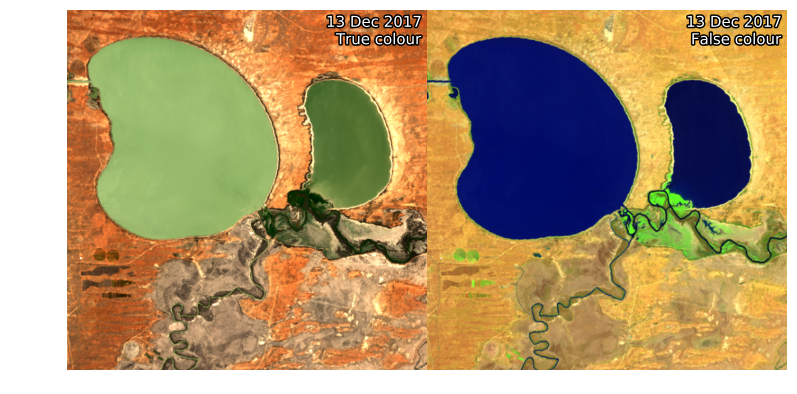

In [29]:
# Animate datasets    
DEAPlotting.animated_doubletimeseries(ds1=ds, ds2=ds, 
                                      output_path='animated_doubletimeseries.gif',
                                      bands1=['red', 'green', 'blue'], 
                                      bands2=['swir1', 'nir', 'green'], 
                                      percentile_stretch2=[0.01, 0.99],
                                      title1="True colour", title2="False colour")


We can also plot a three-band image on one side of the plot, and a single band image on the other side:

Generating 33 frame animation (i.e. timesteps in shortest dataset)
    Exporting animation to animated_doubletimeseries.gif


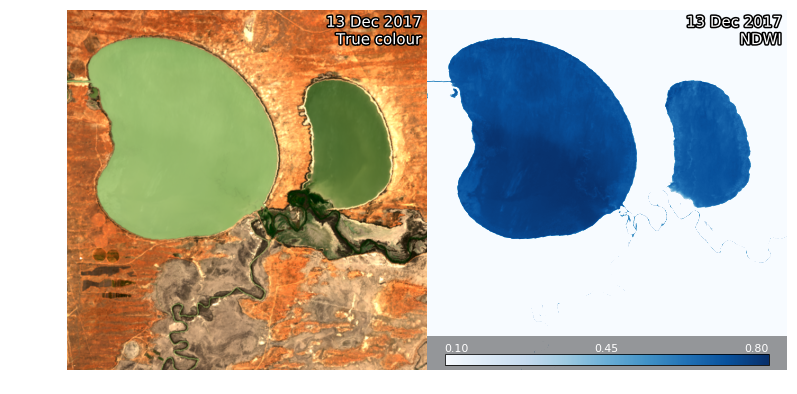

In [31]:
# Animate datasets    
DEAPlotting.animated_doubletimeseries(ds1=ds, ds2=ds, 
                                      output_path='animated_doubletimeseries.gif',
                                      bands1=['red', 'green', 'blue'], bands2=['NDWI'], 
                                      title1='True colour', title2='NDWI',
                                      onebandplot_kwargs2={'cmap':'Blues', 'vmin':0.1, 'vmax':0.8})

Annotations can be customised for each panel individually:

Generating 33 frame animation (i.e. timesteps in shortest dataset)
    Exporting animation to animated_doubletimeseries.gif


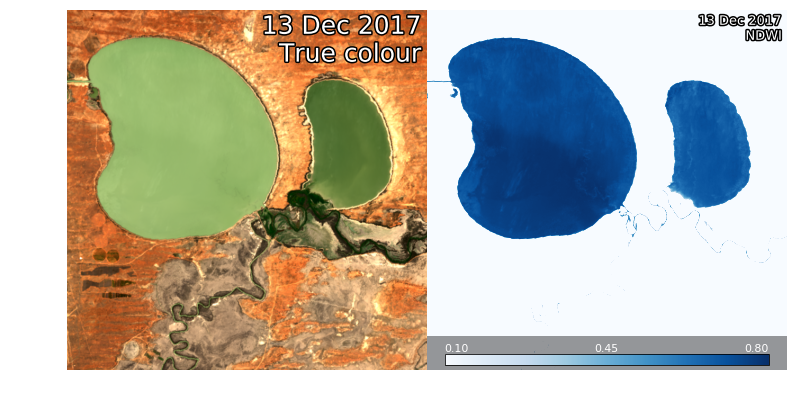

In [33]:
# Animate datasets    
DEAPlotting.animated_doubletimeseries(ds1=ds, ds2=ds, 
                                      output_path='animated_doubletimeseries.gif',
                                      bands1=['red', 'green', 'blue'], bands2=['NDWI'],
                                      title1='True colour', title2='NDWI',
                                      onebandplot_kwargs2={'cmap':'Blues', 'vmin':0.1, 'vmax':0.8},
                                      annotation_kwargs1={'fontsize': 25},
                                      annotation_kwargs2={'fontsize': 13})


## Plotting a side-by-side time series and line graph
The final `animated_timeseriesline` function allows you to plot an xarray dataset in the left panel of the animation, and a set of line graphs from a pandas dataframe in the right hand panel. This may be useful for comparing satellite imagery to time series data like river guages, water quality indices, or pixel drills across time.

First, you need time series data in pandas dataframe format. The dataframe must contain time steps in a `DatetimeIndex` column, and one or more numeric data 
columns to plot as lines in the right panel. Column names are used to label the lines on the plot, so assign them informative names. Lines are plotted by showing all parts of the line with dates on or before the current timestep (i.e. for a 2006 time step, only the portion of the lines with dates on or before 2006 will be plotted for that frame. Here, we will extract a pixel drill of surface water data from the centre of the dataset:

In [56]:
# Extract time series of NDWI values at location (340, 340)
line_df = ds.NDWI.isel(x=340, y=340).to_dataframe()

# Drop all unnecessary columns, and rename to give informative name on plot
line_df.drop(columns=['y', 'x'], inplace=True)
line_df.rename(columns={'NDWI':'Normalized Difference Water Index (NDWI)'}, inplace = True)

# Print first 10 rows
line_df.head(10)


Normalized Difference Water Index (NDWI)
time                                                             
2015-01-22 00:20:21.000                                 -0.520112
2015-02-07 00:20:18.000                                 -0.493437
2015-03-11 00:20:02.000                                 -0.442706
2015-03-27 00:19:53.500                                 -0.448246
2015-07-01 00:19:47.000                                 -0.255748
2015-09-19 00:20:21.000                                 -0.264087
2015-11-22 00:20:32.500                                 -0.228729
2015-12-24 00:20:32.000                                 -0.218396
2016-01-09 00:20:27.500                                 -0.238427
2016-02-10 00:20:23.000                                 -0.222024

    Exporting animation to animated_timeseriesline.gif


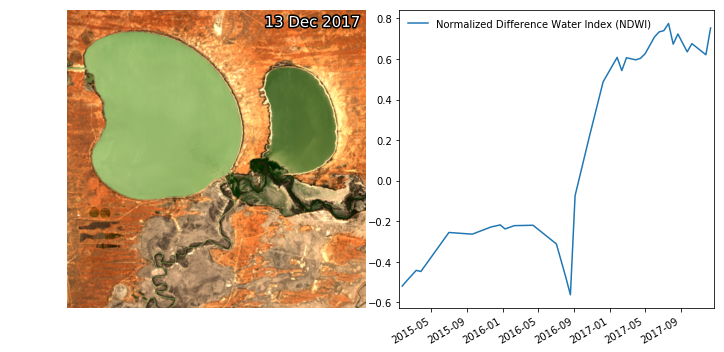

In [36]:
# Animate line plot in right panel of animation  
DEAPlotting.animated_timeseriesline(ds=ds, df=line_df, 
                                    output_path='animated_timeseriesline.gif', 
                                    bands=['red', 'green', 'blue'])


To demonstrate how multiple lines can be added to the same plot:

    Exporting animation to animated_timeseriesline.gif


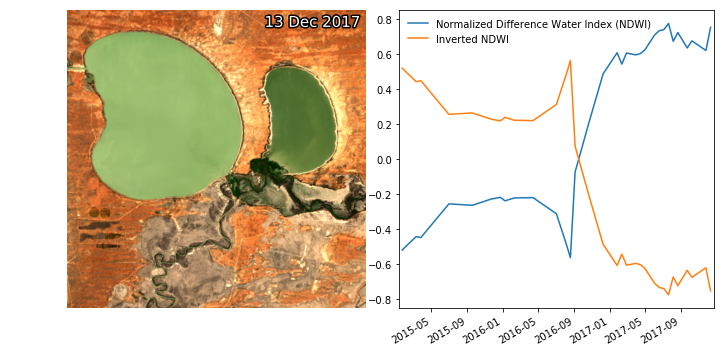

In [37]:
# Add new column to dataframe
line_df['Inverted NDWI'] = line_df['Normalized Difference Water Index (NDWI)'] * -1.0

# Animate line plot in right panel of animation  
DEAPlotting.animated_timeseriesline(ds=ds, df=line_df, 
                                    output_path='animated_timeseriesline.gif', 
                                    bands=['red', 'green', 'blue'])


Lines do not need to have the same timestamps. To combine two different time series, you can simply concatenate the two dataframes and sort by date, and the function will take care of nodata values.

In [49]:
# Create example dataframe
secondline_df = pd.DataFrame(data={'Test data': [0, 0.2, 0.4]}, 
                             index=[pd.Timestamp('2015-06-01'), 
                                    pd.Timestamp('2016-07-01'),
                                    pd.Timestamp('2017-09-01')])

secondline_df

Test data
2015-06-01        0.0
2016-07-01        0.2
2017-09-01        0.4

In [53]:
# Concatenate into one dataframe and sort by date
combinedline_df = pd.concat([line_df, secondline_df])
combinedline_df = combinedline_df.sort_index()

# Print the first 10 rows
combinedline_df.head(10) 

Inverted NDWI  \
2015-01-22 00:20:21.000       0.520112   
2015-02-07 00:20:18.000       0.493437   
2015-03-11 00:20:02.000       0.442706   
2015-03-27 00:19:53.500       0.448246   
2015-06-01 00:00:00.000            NaN   
2015-07-01 00:19:47.000       0.255748   
2015-09-19 00:20:21.000       0.264087   
2015-11-22 00:20:32.500       0.228729   
2015-12-24 00:20:32.000       0.218396   
2016-01-09 00:20:27.500       0.238427   

                         Normalized Difference Water Index (NDWI)  Test data  
2015-01-22 00:20:21.000                                 -0.520112        NaN  
2015-02-07 00:20:18.000                                 -0.493437        NaN  
2015-03-11 00:20:02.000                                 -0.442706        NaN  
2015-03-27 00:19:53.500                                 -0.448246        NaN  
2015-06-01 00:00:00.000                                       NaN        0.0  
2015-07-01 00:19:47.000                                 -0.255748        NaN  
2015-09-19 00:20:21.000                                 -0.264087        NaN  
2015-11-22 00:20:32.500                                 -0.228729        NaN  
2015-12-24 00:20:32.000                                 -0.218396        NaN  
2016-01-09 00:20:27.500                                 -0.238427        NaN

    Exporting animation to animated_timeseriesline.gif


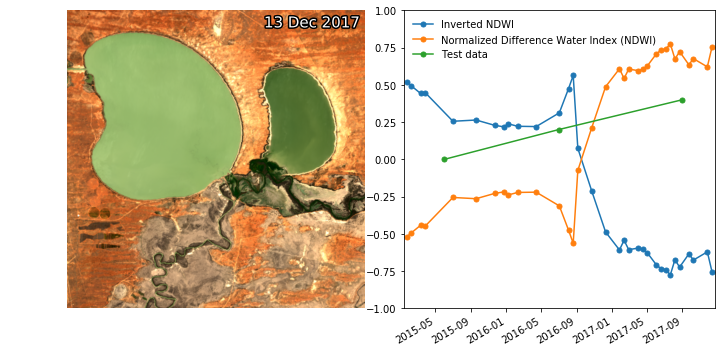

In [55]:
# Animate line plot in right panel of animation, using dots on the lines to highlight each observation point
DEAPlotting.animated_timeseriesline(ds=ds, df=combinedline_df, 
                                    output_path='animated_timeseriesline.gif', 
                                    bands=['red', 'green', 'blue'],
                                    pandasplot_kwargs={'style':'.-', 'ms': 10, 'ylim': (-1.0, 1.0)})


## Available output formats
The above examples have focused on exporting animated GIFs, but MP4 and WMV files can also be generated:
* .mp4: fast to generate, smallest file sizes and often highest quality; suitable for Twitter/social media and recent versions of Powerpoint
* .wmv: slow to generate, large file sizes; suitable for Powerpoint 2010
* .gif: slow to generate, large file sizes; suitable for all versions of Powerpoint and Twitter/social media
    
    
    

Generating 33 frame animation (i.e. timesteps in shortest dataset)
    Exporting animation to animated_doubletimeseries.mp4


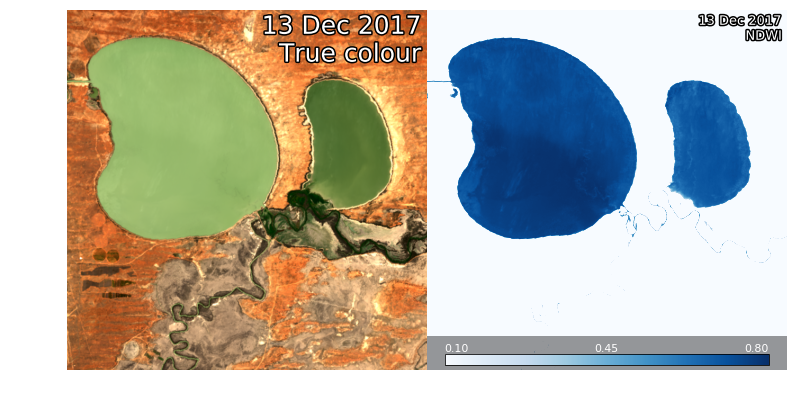

In [38]:
# Animate datasets as a WMV file   
DEAPlotting.animated_doubletimeseries(ds1=ds, ds2=ds, 
                                      output_path='animated_doubletimeseries.wmv',
                                      bands1=['red', 'green', 'blue'], bands2=['NDWI'], 
                                      title1='True colour', title2='NDWI',
                                      onebandplot_kwargs2={'cmap':'Blues', 'vmin':0.1, 'vmax':0.8},
                                      annotation_kwargs1={'fontsize': 25},
                                      annotation_kwargs2={'fontsize': 13})

# Animate datasets as a MP4 file
DEAPlotting.animated_doubletimeseries(ds1=ds, ds2=ds, 
                                      output_path='animated_doubletimeseries.mp4',
                                      bands1=['red', 'green', 'blue'], bands2=['NDWI'], 
                                      title1='True colour', title2='NDWI',
                                      onebandplot_kwargs2={'cmap':'Blues', 'vmin':0.1, 'vmax':0.8},
                                      annotation_kwargs1={'fontsize': 25},
                                      annotation_kwargs2={'fontsize': 13})
